<a href="https://colab.research.google.com/github/theovercomer8/captionr/blob/main/TO8_Captionr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Captionr by theovercomer8
You can find the latest update to the notebook [here](https://github.com/theovercomer8/captionr).


In [ ]:
#@title Install Dependencies
#@markdown Installs requirements and imports CLIP data
import os

if os.path.exists('/content/data'):
  !rm -rf /content/data


if os.path.exists('/content/requirements.txt'):
  !rm /content/requirements.txt

!mkdir /content/data
%cd /content/data


if not os.path.exists('/content/dataset'):
  !mkdir /content/dataset

!wget https://raw.githubusercontent.com/theovercomer8/captionr/main/data/artists.txt
!wget https://raw.githubusercontent.com/jvkap/clip-interrogator/main/clip_interrogator/data/flavors.txt
!wget https://raw.githubusercontent.com/theovercomer8/captionr/main/data/movements.txt
!wget https://raw.githubusercontent.com/theovercomer8/captionr/main/data/mediums.txt

%cd /content
!wget https://raw.githubusercontent.com/theovercomer8/captionr/main/data/requirements.txt

!pip install -r requirements.txt
!apt-get install aria2



In [ ]:
#@title Login to Huggingface hub
from huggingface_hub import login
%store -r

#@markdown Login to Huggingface hub
#@markdown 1. You need a Huggingface account.
#@markdown 2. To create a huggingface token, go to https://huggingface.co/settings/tokens, then create a new token or copy an available token with the `Write` role.
write_token = "" #@param {type:"string"}
login(write_token, add_to_git_credential=True)

%store write_token


In [ ]:
#@title Download and Extract Zip (.zip)
import os
import shutil
from pathlib import Path
%store -r

root_dir = '/content'
#@markdown ### Define Zipfile URL or Zipfile Path
zipfile_url_or_path = "" #@param {'type': 'string'}
zipfile_dst = str(root_dir)+"/zip_file.zip"
extract_to = "/content/dataset" #@param {'type': 'string'}

if extract_to != "":
  os.makedirs(extract_to, exist_ok=True)
else:
  extract_to = "/content/dataset"

#@markdown This will ignore `extract_to` path and automatically extracting to `train_data_dir`
is_dataset = False #@param{'type':'boolean'}

#@markdown Tick this if you want to extract all files directly to `extract_to` folder, and automatically delete the zip to save the memory
auto_unzip_and_delete = False #@param{'type':'boolean'}

dirname = os.path.dirname(zipfile_dst)
basename = os.path.basename(zipfile_dst)

try:
  if zipfile_url_or_path.startswith("/content"):
    zipfile_dst = zipfile_url_or_path
    if auto_unzip_and_delete == False:
      if is_dataset:
        extract_to = "/content/dataset"
      !unzip -j {zipfile_dst} -d "{extract_to}"
  elif zipfile_url_or_path.startswith("https://drive.google.com"):
    !gdown --fuzzy  {zipfile_url_or_path}
  elif zipfile_url_or_path.startswith("magnet:?"):
    !aria2c --summary-interval=10 -c -x 10 -k 1M -s 10 {zipfile_url_or_path}
  elif zipfile_url_or_path.startswith("https://huggingface.co/"):
    if '/blob/' in zipfile_url_or_path:
      zipfile_url_or_path = zipfile_url_or_path.replace('/blob/', '/resolve/')

    hf_token = write_token
    user_header = f"\"Authorization: Bearer {hf_token}\""
    !aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d {dirname} -o {basename} {zipfile_url_or_path}
  else:
    !aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 -d {dirname} -o {basename} {zipfile_url_or_path}

except Exception as e:
  print("An error occurred while downloading the file:", e)

if is_dataset:
  extract_to = '/content/dataset'

if auto_unzip_and_delete:
  !unzip -j {zipfile_dst} -d "{extract_to}"

  path_obj = Path(zipfile_dst)
  zipfile_name = path_obj.parts[-1]
  
  if os.path.isdir(zipfile_dst):
    print("\nThis zipfile doesn't exist or has been deleted \n")
  else:
    os.remove(zipfile_dst)
    print(f"\n{zipfile_name} has been deleted")

In [ ]:
#@title Caption Wizard

from json import JSONDecoder, JSONEncoder
import sys
import getopt
import time
import os, subprocess
from PIL import Image
import torch
from transformers import AutoProcessor, AutoModelForCausalLM, CLIPFeatureExtractor, CLIPModel
import hashlib
import inspect
import math
import numpy as np
import open_clip
import pickle
import time
from dataclasses import dataclass
from blip.models.blip import blip_decoder, BLIP_Decoder
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
from typing import List
from   IPython.core.display import display, HTML
import gc


# All objects we find
json_found = []  
# raw_decode expects byte1 to be part of a JSON, so remove whitespace from left
# stdin = sys.stdin.read().lstrip()
decoder = JSONDecoder()
encoder = JSONEncoder()

#@markdown Folder to scan for images
folder_path = '/content/dataset' #@param {type:"string"}
#@markdown Folder to output captions. Captioned will be named the same as the input image with a .txt extension
output_path = '/content/dataset' #@param {type:"string"}
#@markdown Action to take for existing caption files
existing = 'skip' #@param [ 'skip', 'ignore', 'copy', 'prepend', 'append']
#@markdown Max caption length
cap_length = 150 #@param {type: "slider", min: 0, max: 400}
#@markdown ---
git_pass = True #@param {type:"boolean"}
#@markdown If GIT Pass enabled, fail the caption and move on to BLIP/Coca pass if caption contains any of the following phrases (comma delimted)
git_fail_phrases = 'a sign that says,writing that says,that says,with the word' #@param {type:"string"}
#@markdown Perform a BLIP or Coca caption pass
second_pass = True #@param {type:"boolean"}
second_pass_type = 'Coca' #@param ['BLIP', 'Coca']
#@markdown ---
#@markdown BLIP options if BLIP selected, ignored if Coca selected
blip_beams = 64 #@param {type: "slider", min: 1, max: 100}
blip_min = 30 #@param {type: "slider", min: 5, max: 75}
blip_max = 56 #@param {type: "slider", min: 5, max: 75}

#@markdown ---

clip_model_name = 'ViT-H-14/laion2b_s32b_b79k' #@param ['ViT-L-14/openai',"ViT-H-14/laion2b_s32b_b79k"]

#@markdown Use ViT-H for SD 2.x, ViT-L for SD 1.5
#@markdown
#@markdown Only used if one of the following flavor/artist/medium/movement/trending checkboxes are checked

clip_use_flavor = True #@param {type:"boolean"}
clip_max_flavors = 8 #@param {type: "slider", min: 1, max: 100}
clip_use_artist = False #@param {type:"boolean"}
clip_use_medium = False #@param {type:"boolean"}
clip_use_movement = False #@param {type:"boolean"}
clip_use_trending = False  #@param {type:"boolean"}
#@markdown ---
#@markdown Tags to ignore if they are returned by CLIP
ignore_tags = '' #@param {type:"string"}
#@markdown Find/replace in caption. Set `replace_class` to true to use. Will replace any instances of `sub_class` with `sub_name`
replace_class = False #@param {type:"boolean"}
sub_class = '' #@param {type:"string"}
sub_name = '' #@param {type:"string"}
#@markdown Tag the caption with the containing folder. Useful when using nested folder structure. Can tag up to `folder_tag_levels` deep
folder_tag = False #@param {type:"boolean"}
folder_tag_levels = 1 #@param {type: "slider", min: 1, max: 10}
uniquify_tags = True #@param {type:"boolean"}
#@markdown Tags to prepend or append to the generated caption. Useful for adding a subject or style
prepend_tags = '' #@param {type:"string"}
append_tags = '' #@param {type:"string"}
#@markdown Uncheck `write_to_file` to just perform a preview run
write_to_file = True #@param {type:"boolean"}
#@markdown Read caption from filename if caption file does not exist
use_filename = False #@param {type:"boolean"}

device = "cuda" #if torch.cuda.is_available() else "cpu"
try:
  clip_loaded
except NameError:
  clip_loaded = False
  _clip_model = None
  _clip_preprocess = None
try:
  blip_loaded
except NameError:
  blip_loaded = False  
  _blip_model = None
  
try:
  coca_loaded
except NameError:
  coca_loaded = False  
  coca_processor = None
  coca_model = None
try:
  git_loaded
except NameError:
  git_loaded = False  
  processor = None
  model = None



git_model_name = "microsoft/git-large-r-textcaps"

try:
    cached_for
except NameError:
    cached_for = []
    
if cached_for is None or clip_model_name not in cached_for:
  print("Download preprocessed cache files...")
  CACHE_URLS = [
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-L-14_openai_artists.pkl',
      'https://github.com/theovercomer8/captionr/raw/main/data/ViT-L-14_openai_flavors.pkl',
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-L-14_openai_mediums.pkl',
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-L-14_openai_movements.pkl',
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-L-14_openai_trendings.pkl',
  ] if clip_model_name == 'ViT-L-14/openai' else [
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-H-14_laion2b_s32b_b79k_artists.pkl',
      'https://github.com/theovercomer8/captionr/raw/main/data/ViT-H-14_laion2b_s32b_b79k_flavors.pkl',
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-H-14_laion2b_s32b_b79k_mediums.pkl',
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-H-14_laion2b_s32b_b79k_movements.pkl',
      'https://huggingface.co/pharma/ci-preprocess/resolve/main/ViT-H-14_laion2b_s32b_b79k_trendings.pkl',
  ]
  os.makedirs('cache', exist_ok=True)
  for url in CACHE_URLS:
      subprocess.run(['wget', url, '-P', 'cache'], stdout=subprocess.PIPE)
  cached_for.append(clip_model_name)

def get_parent_folder(filepath, levels=1):
    common = os.path.split(filepath)[0]
    paths = []
    for i in range(int(levels)):
        split = os.path.split(common)
        common = split[0]
        paths.append(split[1])
    return paths

def coca_caption(img):
    im = coca_processor(img).unsqueeze(0).to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
      generated = coca_model.generate(im)

    generated_caption = open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
    return generated_caption

def git_caption(img):
    pixel_values = processor(images=img, return_tensors="pt").pixel_values

    pixel_values = pixel_values.to(device)
    generated_ids = model.generate(pixel_values=pixel_values, max_length=cap_length)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption


        

BLIP_MODELS = {
    'base': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_caption_capfilt_large.pth',
    'large': 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'
}

@dataclass 
class Config:
    # models can optionally be passed in directly
    blip_model: BLIP_Decoder = None
    clip_model = None
    clip_preprocess = None

    # blip settings
    blip_image_eval_size: int = 384
    blip_model_type: str = 'large' # choose between 'base' or 'large'
    blip_offload: bool = False

    # clip settings
    clip_model_path: str = None

    # interrogator settings
    cache_path: str = 'cache'
    chunk_size: int = 2048 if clip_model_name == "ViT-L-14/openai" else 1024
    data_path: str = '/content/data'
    device: str = ("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    flavor_intermediate_count: int = 2048 if clip_model_name == "ViT-L-14/openai" else 1024
    quiet: bool = True # when quiet progress bars are not shown

class Interrogator():
    def __init__(self, config: Config):
        global blip_loaded,_blip_model,clip_loaded,_clip_model
        self.config = config
        self.device = device

        if second_pass and second_pass_type == 'BLIP':
            if config.blip_model is None:
                print("Loading BLIP model...")
                blip_path = os.path.dirname(inspect.getfile(blip_decoder))
                configs_path = os.path.join(os.path.dirname(blip_path), 'configs')
                med_config = os.path.join(configs_path, 'med_config.json')
                blip_model = blip_decoder(
                    pretrained=BLIP_MODELS[config.blip_model_type],
                    image_size=config.blip_image_eval_size, 
                    vit=config.blip_model_type, 
                    med_config=med_config
                )
                blip_model.eval()
                blip_model = blip_model.to(config.device)
                self.blip_model = blip_model
                blip_loaded = True
                _blip_model = blip_model
            else:
                self.blip_model = config.blip_model

        if clip_use_movement or clip_use_artist or clip_use_flavor or clip_use_medium or clip_use_trending:
            self.load_clip_model()

    def load_clip_model(self):
        global clip_loaded, _clip_model, _clip_preprocess
        start_time = time.time()
        config = self.config

        cmn, clip_model_pretrained_name = clip_model_name.split('/', 2)
        if config.clip_model is None:
            print(f"Loading CLIP model...")

            self.clip_model, _, self.clip_preprocess = open_clip.create_model_and_transforms(
                cmn, 
                pretrained=clip_model_pretrained_name, 
                precision='fp16' if config.device == 'cuda' else 'fp32',
                device=config.device,
                jit=False,
                cache_dir=config.clip_model_path
            )
            self.clip_model.to(config.device).eval()
            clip_model = self.clip_model
            clip_loaded = True
            _clip_model = clip_model
            _clip_preprocess = self.clip_preprocess
        else:
            self.clip_model = config.clip_model
            self.clip_preprocess = config.clip_preprocess
        self.tokenize = open_clip.get_tokenizer(cmn)

        sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
        trending_list = [site for site in sites]
        trending_list.extend(["trending on "+site for site in sites])
        trending_list.extend(["featured on "+site for site in sites])
        trending_list.extend([site+" contest winner" for site in sites])

        raw_artists = _load_list(config.data_path, 'artists.txt')
        artists = [f"by {a}" for a in raw_artists]
        artists.extend([f"inspired by {a}" for a in raw_artists])

        if clip_use_artist:
            self.artists = LabelTable(artists, "artists", self.clip_model, self.tokenize, config)
        
        if clip_use_flavor:
            self.flavors = LabelTable(_load_list(config.data_path, 'flavors.txt'), "flavors", self.clip_model, self.tokenize, config)
        
        if clip_use_medium:
            self.mediums = LabelTable(_load_list(config.data_path, 'mediums.txt'), "mediums", self.clip_model, self.tokenize, config)
        
        if clip_use_movement:
            self.movements = LabelTable(_load_list(config.data_path, 'movements.txt'), "movements", self.clip_model, self.tokenize, config)
        
        if clip_use_trending:
            self.trendings = LabelTable(trending_list, "trendings", self.clip_model, self.tokenize, config)

        end_time = time.time()
        print(f"Loaded CLIP model and data in {end_time-start_time:.2f} seconds.")

    def generate_blip_caption(self, pil_image: Image) -> str:
        if self.config.blip_offload:
            self.blip_model = self.blip_model.to(self.device)
        size = self.config.blip_image_eval_size
        gpu_image = transforms.Compose([
            transforms.Resize((size, size), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])(pil_image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            caption = self.blip_model.generate(
                gpu_image, 
                sample=False, 
                num_beams=clip_beams, 
                max_length=clip_max, 
                min_length=clip_min
            )
        if self.config.blip_offload:
            self.blip_model = self.blip_model.to("cpu")
        return caption[0]

    def image_to_features(self, image: Image) -> torch.Tensor:
        images = self.clip_preprocess(image).unsqueeze(0).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = self.clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    
    def interrogate(self, caption: str, image: Image) -> str:
        image_features = self.image_to_features(image)

        # flaves = self.flavors.rank(image_features, self.config.flavor_intermediate_count)
        # best_medium = self.mediums.rank(image_features, 1)[0]
        # best_artist = self.artists.rank(image_features, 1)[0]
        # best_trending = self.trendings.rank(image_features, 1)[0]
        # best_movement = self.movements.rank(image_features, 1)[0]

        best_prompt = caption
        best_sim = self.similarity(image_features, best_prompt)

        def check(addition: str) -> bool:
            nonlocal best_prompt, best_sim
            prompt = best_prompt + ", " + addition
            sim = self.similarity(image_features, prompt)
            if sim > best_sim:
                best_sim = sim
                best_prompt = prompt
                return True
            return False

        def check_multi_batch(opts: List[str]):
            nonlocal best_prompt, best_sim
            prompts = []
            for i in range(2**len(opts)):
                prompt = best_prompt
                for bit in range(len(opts)):
                    if i & (1 << bit):
                        prompt += ", " + opts[bit]
                prompts.append(prompt)

            t = LabelTable(prompts, None, self.clip_model, self.tokenize, self.config)
            best_prompt = t.rank(image_features, 1)[0]
            best_sim = self.similarity(image_features, best_prompt)

        batch = []

        if clip_use_artist:
            batch.append(self.artists.rank(image_features,1)[0])
        if clip_use_flavor:
                best_flavors = self.flavors.rank(image_features, self.config.flavor_intermediate_count)
                extended_flavors = set(best_flavors)
                for _ in tqdm(range(clip_max_flavors), desc="Flavor chain", disable=self.config.quiet):
                    best = self.rank_top(image_features, [f"{best_prompt}, {f}" for f in extended_flavors])
                    flave = best[len(best_prompt) + 2:]
                    if not check(flave):
                        break
                    if _prompt_at_max_len(best_prompt, self.tokenize):
                        break
                    extended_flavors.remove(flave)
        if clip_use_medium:
            batch.append(self.mediums.rank(image_features, 1)[0])
        if clip_use_trending:
            batch.append(self.trendings.rank(image_features, 1)[0])
        if clip_use_movement:
            batch.append(self.movements.rank(image_features, 1)[0])

        check_multi_batch(batch)
        tags = best_prompt.split(",")

        return tags
        # check_multi_batch([best_medium, best_artist, best_trending, best_movement])

        # extended_flavors = set(flaves)
        # for _ in tqdm(range(max_flavors), desc="Flavor chain", disable=self.config.quiet):
        #     best = self.rank_top(image_features, [f"{best_prompt}, {f}" for f in extended_flavors])
        #     flave = best[len(best_prompt)+2:]
        #     if not check(flave):
        #         break
        #     if _prompt_at_max_len(best_prompt, self.tokenize):
        #         break
        #     extended_flavors.remove(flave)

        # return best_prompt

    def rank_top(self, image_features: torch.Tensor, text_array: List[str]) -> str:
        text_tokens = self.tokenize([text for text in text_array]).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features @ image_features.T
        return text_array[similarity.argmax().item()]

    def similarity(self, image_features: torch.Tensor, text: str) -> float:
        text_tokens = self.tokenize([text]).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features @ image_features.T
        return similarity[0][0].item()


class LabelTable():
    def __init__(self, labels:List[str], desc:str, clip_model, tokenize, config: Config):
        self.chunk_size = config.chunk_size
        self.config = config
        self.device = config.device
        self.embeds = []
        self.labels = labels
        self.tokenize = tokenize

        hash = hashlib.sha256(",".join(labels).encode()).hexdigest()

        cache_filepath = None
        if config.cache_path is not None and desc is not None:
            os.makedirs(config.cache_path, exist_ok=True)
            sanitized_name = clip_model_name.replace('/', '_').replace('@', '_')
            cache_filepath = os.path.join(config.cache_path, f"{sanitized_name}_{desc}.pkl")
            if desc is not None and os.path.exists(cache_filepath):
                with open(cache_filepath, 'rb') as f:
                    try:
                        data = pickle.load(f)
                        if data.get('hash') == hash:
                            self.labels = data['labels']
                            self.embeds = data['embeds']
                    except Exception as e:
                        print(f"Error loading cached table {desc}: {e}")

        if len(self.labels) != len(self.embeds):
            self.embeds = []
            chunks = np.array_split(self.labels, max(1, len(self.labels)/config.chunk_size))
            for chunk in tqdm(chunks, desc=f"Preprocessing {desc}" if desc else None, disable=self.config.quiet):
                text_tokens = self.tokenize(chunk).to(self.device)
                with torch.no_grad(), torch.cuda.amp.autocast():
                    text_features = clip_model.encode_text(text_tokens)
                    text_features /= text_features.norm(dim=-1, keepdim=True)
                    text_features = text_features.half().cpu().numpy()
                for i in range(text_features.shape[0]):
                    self.embeds.append(text_features[i])

            if cache_filepath is not None:
                with open(cache_filepath, 'wb') as f:
                    pickle.dump({
                        "labels": self.labels, 
                        "embeds": self.embeds, 
                        "hash": hash, 
                        "model": clip_model_name
                    }, f)

        if self.device == 'cpu' or self.device == torch.device('cpu'):
            self.embeds = [e.astype(np.float32) for e in self.embeds]
    
    def _rank(self, image_features: torch.Tensor, text_embeds: torch.Tensor, top_count: int=1) -> str:
        top_count = min(top_count, len(text_embeds))
        text_embeds = torch.stack([torch.from_numpy(t) for t in text_embeds]).to(self.device)
        with torch.cuda.amp.autocast():
            similarity = image_features @ text_embeds.T
        _, top_labels = similarity.float().cpu().topk(top_count, dim=-1)
        return [top_labels[0][i].numpy() for i in range(top_count)]

    def rank(self, image_features: torch.Tensor, top_count: int=1) -> List[str]:
        if len(self.labels) <= self.chunk_size:
            tops = self._rank(image_features, self.embeds, top_count=top_count)
            return [self.labels[i] for i in tops]

        num_chunks = int(math.ceil(len(self.labels)/self.chunk_size))
        keep_per_chunk = int(self.chunk_size / num_chunks)

        top_labels, top_embeds = [], []
        for chunk_idx in tqdm(range(num_chunks), disable=self.config.quiet):
            start = chunk_idx*self.chunk_size
            stop = min(start+self.chunk_size, len(self.embeds))
            tops = self._rank(image_features, self.embeds[start:stop], top_count=keep_per_chunk)
            top_labels.extend([self.labels[start+i] for i in tops])
            top_embeds.extend([self.embeds[start+i] for i in tops])

        tops = self._rank(image_features, top_embeds, top_count=top_count)
        return [top_labels[i] for i in tops]


def _load_list(data_path: str, filename: str) -> List[str]:
    with open(os.path.join(data_path, filename), 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def _merge_tables(tables: List[LabelTable], config: Config) -> LabelTable:
    m = LabelTable([], None, None, None, config)
    for table in tables:
        m.labels.extend(table.labels)
        m.embeds.extend(table.embeds)
    return m

def _prompt_at_max_len(text: str, tokenize) -> bool:
    tokens = tokenize([text])
    return tokens[0][-1] != 0

def _truncate_to_fit(text: str, tokenize) -> str:
    parts = text.split(', ')
    new_text = parts[0]
    for part in parts[1:]:
        if _prompt_at_max_len(new_text + part, tokenize):
            break
        new_text += ', ' + part
    return new_text

ci:Interrogator = None

        
def process_img(img_path):

    display(HTML(f'<div>-----</div><h1>{img_path}</h1>'))
    # Load image
    with Image.open(img_path).convert('RGB') as img:
      display(img.resize((200,200)))
      # Get existing caption
      existing_caption = ''
      cap_file = os.path.join(folder_path,os.path.splitext(os.path.split(img_path)[1])[0] + '.txt')
      if os.path.isfile(cap_file):
        with open(cap_file) as f:
          existing_caption = f.read()

      # Get caption from filename if empty
      if existing_caption == '' and use_filename:
          path = os.path.split(img_path)[1]
          path = os.path.splitext(path)[0]
          existing_caption = ''.join(c for c in path if c.isalpha() or c in [" ", ","])
      
      
      # Create tag list
      out_tags = []
      new_caption = ''
    
      # 1st caption pass: GIT
      if git_pass:
          new_caption = git_caption(img)
          # Check if caption fails from list of not-allowed phrases
          if second_pass and any(f in new_caption for f in git_fail_phrases.split(',')):
              # Fail git caption
              print(f'GIT caption was\n{new_caption}\nGIT Fail phrases detected. Beginning second pass.')
              new_caption = ''


      # 2nd caption pass: (if failed)
      if second_pass and new_caption == '':
        if second_pass_type == 'BLIP':
          new_caption = ci.generate_blip_caption(img)
        else:
          new_caption = coca_caption(img)




      # Add enabled CLIP flavors to tag list
      if clip_use_artist or clip_use_flavor or clip_use_medium or clip_use_movement or clip_use_trending:
          tags = ci.interrogate(new_caption,img)
          for tag in tags:
              out_tags.append(tag)
      else:
          for tag in new_caption.split(","):
              out_tags.append(tag)


      # Add parent folder to tag list if enabled
      if folder_tag:
          folder_tags = get_parent_folder(img_path,folder_tag_levels)
          for tag in folder_tags:
              out_tags.append(tag)

      # Remove duplicates, filter dumb stuff
      # chars_to_strip = ["_\\("]
      unique_tags = []
      tags_to_ignore = []
      if ignore_tags != "" and ignore_tags is not None:
          si_tags = ignore_tags.split(",")
          for tag in si_tags:
              tags_to_ignore.append(tag.strip)

      if uniquify_tags:
          for tag in out_tags:
              if not tag in unique_tags and not "_\(" in tag and not tag in ignore_tags:
                  unique_tags.append(tag.strip())
      else:
          for tag in out_tags:
              if not "_\(" in tag and not tag in ignore_tags:
                  unique_tags.append(tag.strip())

      existing_tags = existing_caption.split(",")

      # APPEND/PREPEND/OVERWRITE existing caption based on options
      if existing == "prepend" and len(existing_tags):
          new_tags = existing_tags
          for tag in unique_tags:
              if not tag in new_tags or not uniquify_tags:
                  new_tags.append(tag)
          unique_tags = new_tags

      if existing == 'append' and len(existing_tags):
          for tag in existing_tags:
              if not tag in unique_tags or not uniquify_tags:
                  unique_tags.append(tag)

      if existing == 'copy' and existing_caption:
          for tag in existing_tags:
              unique_tags.append(tag.strip())

      if append_tags != '':
          for tag in append_tags.split(','):
              unique_tags.append(tag.strip())
      
      if prepend_tags != '':
          for tag in prepend_tags.split(','):
              unique_tags.insert(0,tag.strip())


      # Construct new caption from tag list
      caption_txt = ", ".join(unique_tags)

      if replace_class and sub_name is not None and sub_class is not None:
          # Find and replace "a SUBJECT CLASS" in caption_txt with subject name
          if f"a {sub_class}" in caption_txt:
              caption_txt = caption_txt.replace(f"a {sub_class}", sub_name)

          if sub_class in caption_txt:
              caption_txt = caption_txt.replace(sub_class, sub_name)

      tags = caption_txt.split(" ")
      if cap_length != 0 and len(tags) > cap_length:
              tags = tags[0:cap_length]
              tags[-1] = tags[-1].rstrip(",")
      caption_txt = " ".join(tags)

      # Write caption file
      if write_to_file:
          with open(os.path.join(output_path,cap_file), "w", encoding="utf8") as file:
                      file.write(caption_txt)
                      print(f'Wrote {cap_file}')

      display(HTML(f'<h2>Final Caption</h2><div>{caption_txt}</div>'))



# processor = None
# model = None
# coca_processor = None
# coca_model = None
# ci = None
# with torch.no_grad():
#     torch.cuda.empty_cache()
# gc.collect()

try:
  if git_pass:
    if not git_loaded or processor is None or  model is None:
      print('Loading GIT model...')
      processor = AutoProcessor.from_pretrained(git_model_name)
      model = AutoModelForCausalLM.from_pretrained(git_model_name)
      model.to(device)
      git_loaded = True
  else:
    if git_loaded:
      git_loaded = False
      processor = None
      model = None
      gc.collect()
      with torch.no_grad():
        torch.cuda.empty_cache()
  if second_pass and second_pass_type == 'Coca':
    if not coca_loaded or coca_model is None or coca_processor is None:
      print('Loading Coca model...')
      coca_model, _, coca_processor = open_clip.create_model_and_transforms(
        model_name="coca_ViT-L-14",
        pretrained="mscoco_finetuned_laion2B-s13B-b90k"
      )
      coca_model.to(device)
      coca_loaded = True
    elif not coca_loaded:
      if coca_loaded:
        coca_loaded = False
        coca_model = None
        coca_processor = None
        _ = None
        gc.collect()

        with torch.no_grad():
          torch.cuda.empty_cache()
  else:
      if coca_loaded:
        coca_loaded = False
        coca_model = None
        coca_processor = None
        _ = None
        gc.collect()

        with torch.no_grad():
          torch.cuda.empty_cache()

  if clip_use_movement or clip_use_artist or clip_use_flavor or clip_use_medium or clip_use_trending or (second_pass and second_pass_type == 'BLIP'):
      # if (not clip_loaded and (clip_use_movement or clip_use_artist or clip_use_flavor or clip_use_medium or clip_use_trending)) or (not blip_loaded and (second_pass and second_pass_type == 'BLIP')):
        # print(f'clip_loaded:{clip_loaded}\nclip_user_movement:{clip_use_movement}\nclip_use_artist:{clip_use_artist}\nclip_use_medium:{clip_use_medium}\nclip_use_trending:{clip_use_trending}\nblip_loaded:{blip_loaded}\nsecond_pass:{second_pass}\nsecond_pass_type:{second_pass_type}')
        ci = None
        gc.collect()
        with torch.no_grad():
          torch.cuda.empty_cache()
        cfg = Config(quiet=False)
        cfg.clip_model = _clip_model
        cfg.clip_preprocess = _clip_preprocess
        cfg.blip_model = _blip_model
        ci = Interrogator(cfg)


  for root, dirs, files in os.walk(folder_path, topdown=False):
    for name in files:
      if 'txt' not in os.path.splitext(os.path.split(name)[1])[1]:
        cap_file = os.path.join(folder_path,os.path.splitext(os.path.split(name)[1])[0] + '.txt')
        if not existing == 'skip' or not os.path.exists(cap_file):
          process_img(os.path.join(root, name))
        else:
          print(f'Caption file {cap_file} exists. Skipping.')

  
# except Exception as e:
#   print(f'Exception occurred: {e}')

finally:
  # processor = None
  # model = None

  # coca_processor = None
  # coca_model = None
  # ci = None
  # with torch.no_grad():
  #     torch.cuda.empty_cache()
  gc.collect()
   

In [ ]:
#@title Define your Huggingface Repo

from huggingface_hub import HfApi
from huggingface_hub.utils import validate_repo_id, HfHubHTTPError
%store -r

api = HfApi()
user = api.whoami(write_token)

#@markdown #### If your model/dataset repo doesn't exist, it will automatically create your repo.
dataset_name = "" #@param{type:"string"}
make_this_dataset_private = True #@param{type:"boolean"}

datasets_repo = user['name']+"/"+dataset_name.strip()

if dataset_name != "":
  try:
      validate_repo_id(datasets_repo)
      api.create_repo(repo_id=datasets_repo,
                      repo_type="dataset",
                      private=make_this_dataset_private)
      print("Dataset Repo didn't exists, creating repo")
      print("Dataset Repo",datasets_repo,"created!\n")

  except HfHubHTTPError as e:
      print(f"Dataset repo: {datasets_repo} exists, skipping create repo\n")


In [ ]:
#@title Upload Dataset
from huggingface_hub import HfApi
from pathlib import Path
import shutil
import zipfile
import os

api = HfApi()

#@markdown #### This will be compressed to zip and  uploaded to datasets repo, leave it empty if not necessary
dataset_path = "/content/dataset" #@param {type :"string"}
dataset_name = "dataset" #@param {type :"string"}
#@markdown #### Delete zip after upload
delete_zip = True #@param {type :"boolean"}

tmp_dataset = "/content/dataset"

dataset_zip = f"/content/{dataset_name}.zip"


#@markdown #### Other Information
commit_message = "" #@param {type :"string"}

if not commit_message:
  commit_message = "feat: upload captioned dataset"

def upload_dataset(dataset_paths, is_zip : bool):
  path_obj = Path(dataset_paths)
  dataset_name = path_obj.parts[-1]

  if is_zip:
    print(f"Uploading dataset to https://huggingface.co/datasets/"+datasets_repo)
    print(f"Please wait...")

    api.upload_file(
        path_or_fileobj=dataset_paths,
        path_in_repo=dataset_name,
        repo_id=datasets_repo,
        repo_type="dataset",
        commit_message=commit_message,
    )
    print(f"Upload success, located at https://huggingface.co/datasets/"+datasets_repo+"/blob/main/"+dataset_name+"\n")
  else:
    print(f"Uploading {dataset_name} to https://huggingface.co/datasets/"+datasets_repo)
    print(f"Please wait...")

    api.upload_folder(
        folder_path=dataset_paths,
        path_in_repo=dataset_name,
        repo_id=datasets_repo,
        repo_type="dataset",
        commit_message=commit_message,
        ignore_patterns=".ipynb_checkpoints",
    )
    print(f"Upload success, located at https://huggingface.co/datasets/"+datasets_repo+"/tree/main/"+dataset_name+"\n")
  
def zip_file(tmp,zip):
    zipfiles = zip 
    with zipfile.ZipFile(zipfiles, 'w') as zip:
      for tmp, dirs, files in os.walk(tmp):
          for file in files:
              zip.write(os.path.join(tmp, file))

def upload():
  zip_file(tmp_dataset,dataset_zip)
  upload_dataset(dataset_zip, True)
  if delete_zip:
    os.remove(dataset_zip)

upload()




<a href="https://www.buymeacoffee.com/theovercomer8" target="_blank">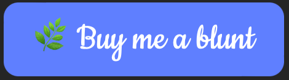</a>